> Done by Alfredo Fernández Guaza


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlfredoFernandezGuaza/deepknob/blob/master/DeepKnob.ipynb)

# Installation
## 1.  Create a zip called 'deepknob-data.zip'
This zip needs to contain:
*   Directory called 'data' with the dataset inside named as 'final_dataset.csv'

## 2.  Upload deepknob-data.zip
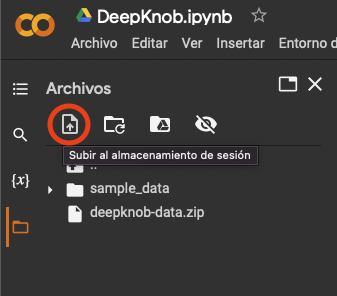
## 3. Unzip deepknob-data.zip and create models directory

In [ ]:
!unzip deepknob-data.zip &> /dev/null
!rm deepknob-data.zip &> /dev/null
!rm -r models &> /dev/null
!mkdir models &> /dev/null

# DeepKnob
User identification from data retrieved by sensors using neural networks.

In [ ]:
import tensorflow
from tensorflow import keras

print('Tensorflow version:', keras.__version__)

Tensorflow version: 2.8.0


## Dataset
Contains:
<ol style="margin-top:0; font-weight:bold">
    <li>
        <span>Header:</span>
        <span style="font-weight:normal"> user_ID, attempt, time(us), accX(g), accY(g), accZ(g), gyrX(o/s), gyrY(o/s), gyrZ(o/s).</span>
    </li>
    <li>
        <span>Data:</span>
        <span style="font-weight:normal">NOT normalized data.</span>
    </li>
    <li>
        <span>Empty Line:</span>
        <span style="font-weight:normal">Last line is empty, so we do not use it.</span>
    </li>
</ol>



### Opening the dataset
Getting Data from Dataset

In [ ]:
import os
dir = './'
data_dir = os.path.join(dir, 'data')
fname = os.path.join(data_dir, 'final_dataset.csv')

f = open(fname)
raw_data = f.read()
f.close()

lines = raw_data.split('\n')
lines = lines[:-1]
header = lines[0].split(',')
lines = lines[1:]

print('Number of lines:', len(lines))
print("First line:", lines[0])
print("Last line:", lines[-1])

Number of lines: 1405300
First line: 1,1,0,1.009766,-0.016602,0.016602,0.900763,0.152672,-0.778626
Last line: 47,20,2478561,1.009277,0.021484,-0.015137,0.748092,0.076336,-0.48855


### Process the raw data
Get list of accelerometer and gyroscope floating point values from row data. \
Each list item is one measure of the accelerometer and gyrocope in the 3 dimensional axis.

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header)))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')]
    float_data[i, :] = values

first_column = 3 
last_column = 9
columns = last_column - first_column
data = float_data[:,first_column:last_column]

### One hot encoding of data labels
Get the labels of each attempt. \
One attempt is compose by a number of measures. \
The label is the user_ID who made the attempt. \
Then vectorize each label as a vector [0,0,...,0,1,0,...,0,0] which length is the number of different users. \
Number 1 in the one_hot label vector means the user_ID index who made the attempt.

In [ ]:
from tensorflow.keras.utils import to_categorical

measures_per_attempt = 1495
labels = float_data[::measures_per_attempt, 0]

labels = labels-1
labels = labels.astype('int32')

labels = to_categorical(labels)

### Reshape data into shape (samples, timesteps, features)
The number of classes or categories is each label length, which is the same for every label.\
The number of attempts is the attempts done by each user, which is the same for every user.\
The new data consists of 3D tensor which shape is the following:
<ol style="margin-top:0; font-weight:bold">
    <li>
        <span>Samples:</span>
        <span style="font-weight:normal">How many times every user has done an attempt.</span>
    </li>
    <li>
        <span>Timesteps:</span>
        <span style="font-weight:normal">How many measures are done in an attempt by one user.</span>
    </li>
    <li>
        <span>Features:</span>
        <span style="font-weight:normal">The different types of measures done each timestep.</span>
    </li>
</ol>

In [ ]:
categories = labels.shape[-1]
attempts = int(float_data[-1, 1])

samples = categories * attempts
sensor_readings = len(lines) // samples

data = data.reshape(samples, sensor_readings, columns)

### Remove useless data
Remove the data of measures taken before the contact with the knob.

In [ ]:
batch_begin = 244

data = data[:,batch_begin:,:]

### Plot data
Show data to know where to cut.

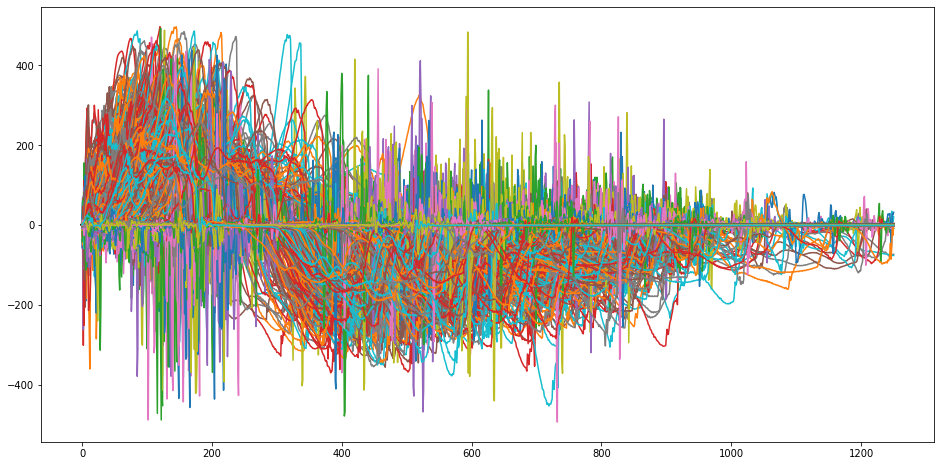

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(figsize=(16, 8))
for i, val in enumerate(data):
	axs.plot(data[i,:,:])
axs.grid=True

### Shuffle training, validation and test samples
Shuffle each subset sample one by one. 

In [ ]:
import random

def shuffle(all_data, all_labels):
    
    data_samples = len(all_data)

    shuffled_indices = []
    
    split_attempts = data_samples // categories
    random_indices = [i for i in range(split_attempts)]

    shuffled_categories = [i for i in range(categories)]
    random.shuffle(shuffled_categories)
    
    for category in shuffled_categories:
        random.shuffle(random_indices)
        for i in random_indices:
            shuffled_indices.append(split_attempts * category + i)

    shuffled_data = all_data[shuffled_indices,:,:]
    shuffled_labels = all_labels[shuffled_indices,:]

    return shuffled_data, shuffled_labels

#### Shuffle data samples
Shuffle samples so there are the same number of samples per category

In [ ]:
data, labels = shuffle(data, labels)

### Split data into training, validation and testing
Use the shuffled indices to split data in:
<ol style="margin-top:0; font-weight:bold">
    <li>
        <span>Training:</span>
        <span style="font-weight:normal">Data which will feed the model.</span>
    </li>
    <li>
        <span>Validation:</span>
        <span style="font-weight:normal">Data used to know how well the model generalize with new data. This data is sensible to model's hyperparameters tuning.</span>
    </li>
    <li>
        <span>Testing:</span>
        <span style="font-weight:normal">Data which allows the real model performance.</span>
    </li>
</ol>

In [ ]:
def split(all_data, all_labels, validation=0.2):
    
    data_samples = len(data)
    split_attempts = data_samples // categories
    validation_attempts = split_attempts * int((1. - validation) * 100) // 100

    train_indices = []
    validation_indices = []
    
    indices = [i for i in range(split_attempts)] 
    
    for category in range(categories):
        for i in range(validation_attempts): 
            train_indices.append(split_attempts * category + i)  
        for i in range(validation_attempts, split_attempts):
            validation_indices.append(split_attempts * category + i) 

    x_train = all_data[train_indices,:,:]
    y_train = all_labels[train_indices,:]

    x_validation = all_data[validation_indices,:,:]
    y_validation = all_labels[validation_indices,:]

    return x_train, y_train, x_validation, y_validation

#### Get test data

In [ ]:
x_train_and_validation, y_train_and_validation, x_test, y_test = split(data, labels, validation=0.2)

#### Split training and test data

In [ ]:
x_train, y_train, x_validation, y_validation = split(data, labels, validation=0.25)

## Machine learning approach
Different layers from Keras layers API are used, layers are the basic block ok neural networks in Keras.
The used Model layers consists:
<ul style="margin-top:0; font-weight:bold">
    <li>
        <span>Normalization:</span>
        <span style="font-weight:normal">This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.</span>
    </li>
    <li>
        <span>LSTM:</span>
        <span style="font-weight:normal">Long Short-Term Memory layer, an recurrent neural network which takes into acount time series data.</span>
    </li>
    <li>
        <span>Bidirectional:</span>
        <span style="font-weight:normal">Wrapper of recurrent neural networks which allows to process data forward (from past to future) and backwards (from future to past).</span>
    </li>
    <li>
        <span>Conv1D:</span>
        <span style="font-weight:normal">The kernel is a window of specified size. Convolutions are the product of doing mathematical operations, mainly scalar products of kernel window size over the input. A filter is a group of kernels, number of kernels is also specified. This layer produce as many convolutions as filters specified. The goal of this layer is learn spatial hierarchies of patterns.</span>
    </li>
    <li>
        <span>MaxPooling1D:</span>
        <span style="font-weight:normal">The input is divided by a specified integer, in each section produced by the division produce a float with the max value of the section. The purspose of this layer is to down-sample the input, reducing its dimesionality.</span>
    </li>
    <li>
        <span>GloabalMaxPool1D:</span>
        <span style="font-weight:normal">Down-samples the input representation by taking the maximum value over the time dimension.</span>
    </li>
    <li>
        <span>Flatten:</span>
        <span style="font-weight:normal">Flattens the input into shape(none, x), where x is the multiplication of input shapes.</span>
    </li>
    <li>
        <span>Dense:</span>
        <span style="font-weight:normal">Regular densely-connected neural network layer. Each layer neuron recives input from all previos layer neurons. Then a non-linear transformation is done to produce output.</span>
    </li>
    <li>
        <span>Dropout:</span>
        <span style="font-weight:normal">Sets randomly input units to 0 with a specified frecuency.</span>
    </li>
</ul>

### Model creation
Compose by:
1.  Preprocesing normalization layer - All data at same scale.
2.  Recurrent and convolutional base - Get features from input data.
3.  Classifier - Classify by previous gotten features.

In [ ]:
from keras import Input 
from keras.models import Model
from keras.layers.preprocessing.normalization import Normalization
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers.core import Dense
from keras.activations import relu, softmax

def create_model(x_train, summary=True):
  
    # Preprocessing Normalization
    normalizeLayer = Normalization()
    normalizeLayer.adapt(x_train)

    input_tensor = Input(shape=x_train.shape[1:])
    common_input = normalizeLayer(input_tensor)

    # Recurrent and Covolutional Base
    tensor = Conv1D(47, 7, activation=relu)(common_input)
    tensor = MaxPooling1D(5)(tensor)
    tensor = Conv1D(74, 7, activation=relu)(tensor)
    tensor = MaxPooling1D(3)(tensor)
    tensor = Bidirectional(LSTM(37, return_sequences=True))(tensor)
    tensor = Conv1D(59, 7, activation=relu)(tensor)
    tensor = MaxPooling1D(3)(tensor)
    tensor = GlobalMaxPooling1D()(tensor)
  
    # Classifier
    output_tensor = Dense(47, activation=softmax)(tensor)

    model = Model(input_tensor, output_tensor)

    if summary: model.summary()

    return model

model = create_model(x_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1251, 6)]         0         
                                                                 
 normalization (Normalizatio  (None, 1251, 6)          13        
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 1245, 47)          2021      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 47)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 243, 74)           24420     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 81, 74)           0     

### Model callbacks
The model stops training if two conditions are met:

*   Number of epochs with no improvement is greater than an specified variable.
*   Training loss is less than 0.1 or validation accuracy is greater than threashold.





In [ ]:
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler 

class ThresholdCallback(Callback):
    def __init__(self, threshold, max_loss=0.1, patience=0):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold
        self.max_loss = max_loss
        self.patience = patience
        
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None): 
        val_accuracy = logs.get('val_categorical_accuracy')
        current = logs.get('loss')
        
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            is_patience_end = self.wait >= self.patience
            is_out_of_threshold = val_accuracy > self.threshold
            is_less_than_max_loss = current < self.max_loss
            stop = is_patience_end and (is_out_of_threshold or is_less_than_max_loss)
            if stop:
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
        

models_dir = os.path.join(dir, 'models')
model_path = os.path.join(models_dir, 'deepknob.h5')

threshold = ThresholdCallback(threshold=0.9, patience=1)

checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_categorical_accuracy',
                             save_best_only=True)

def scheduler(epoch, lr):
    if epoch == 15:
        return lr / 2

    return lr

scheduler = LearningRateScheduler(scheduler)

### Compile and fit the model
Due to DeepKnob is a classification so problem *categorical_crossentropy* is used. 

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

def compile_and_fit(model, x_train, y_train, x_validation, y_validation, save_model=False):
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=[categorical_accuracy])

    return model.fit(x_train,
                     y_train,
                     epochs = 20,
                     batch_size = 32,
                     callbacks = [threshold, checkpoint, scheduler] if save_model else [threshold, scheduler],
                     validation_data = (x_validation, y_validation),
                     verbose = 1 if save_model else 0)

history = compile_and_fit(model, x_train, y_train, x_validation, y_validation, save_model=True)

Epoch 1/20
23/23 [==============================] - 8s 203ms/step - loss: 3.8646 - categorical_accuracy: 0.0227 - val_loss: 3.7903 - val_categorical_accuracy: 0.0383 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - 4s 155ms/step - loss: 3.7600 - categorical_accuracy: 0.0440 - val_loss: 3.6848 - val_categorical_accuracy: 0.0638 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - 4s 155ms/step - loss: 3.5400 - categorical_accuracy: 0.0936 - val_loss: 3.3907 - val_categorical_accuracy: 0.1362 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - 4s 158ms/step - loss: 3.0558 - categorical_accuracy: 0.2156 - val_loss: 2.7168 - val_categorical_accuracy: 0.3191 - lr: 0.0010
Epoch 5/20
23/23 [==============================] - 4s 156ms/step - loss: 2.4442 - categorical_accuracy: 0.3362 - val_loss: 2.1329 - val_categorical_accuracy: 0.4128 - lr: 0.0010
Epoch 6/20
23/23 [==============================] - 4s 157ms/step - loss: 1.8166 - categorical_accuracy: 

### A way to get a smoth curve
Each point from a list is treated in order to show a smoth curve if it is plotted in a graph.

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

### Model loss and validation loss
If loss ≈ validation loss, there is no overfitting neither underfitting.\
If loss < validation loss, there is overfitting.\
If loss > validation loss, there is underfitting.

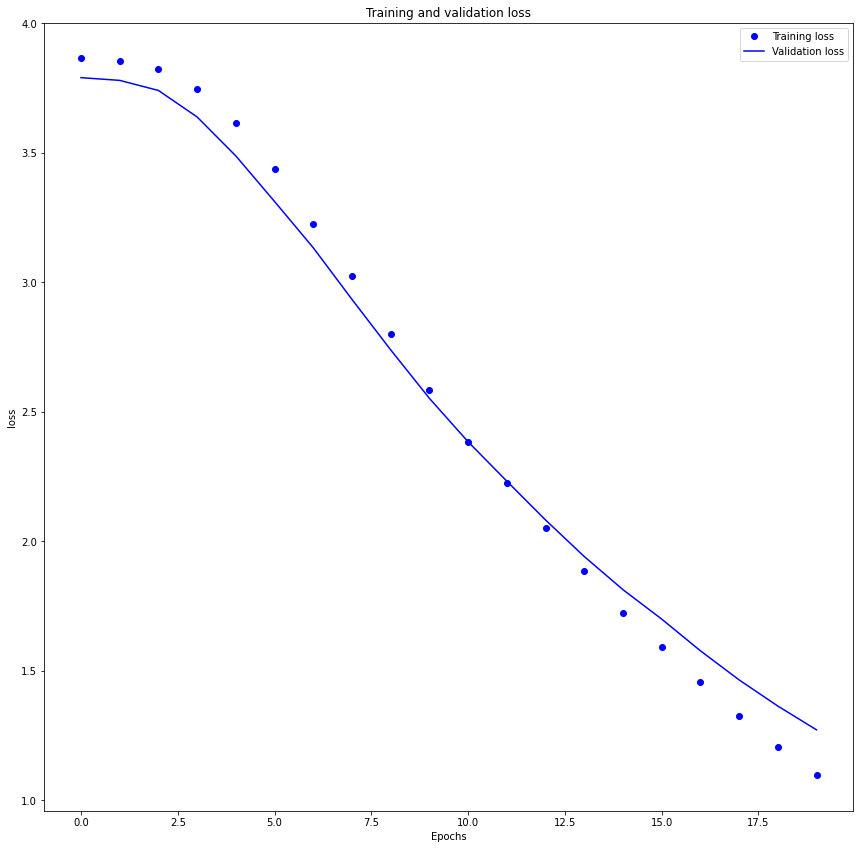

In [ ]:
def plot_metric(history, metric, color):
    metric_value = smooth_curve(history.history[metric])
    val_metric_value = smooth_curve(history.history['val_' + metric])

    epochs = range(len(metric_value))

    plt.figure(figsize=(14.5, 14.5))

    plt.plot(epochs, metric_value, color + 'o', label='Training ' + metric)
    plt.plot(epochs, val_metric_value, color, label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.show()

plot_metric(history, 'loss', 'b')

### Model accuracy and validation accuracy
Accuracy shows the probability of identify the right user.

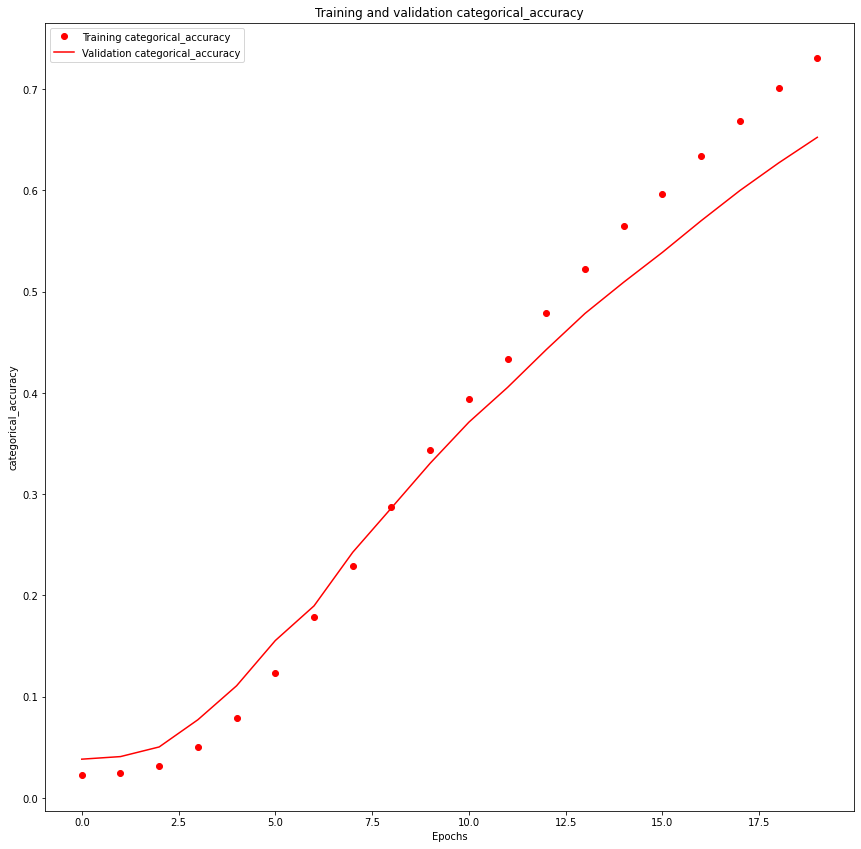

In [ ]:
plot_metric(history, 'categorical_accuracy', 'r')

## Evaluation on test data
Shows how well the model generalize

In [ ]:
model = keras.models.load_model(model_path)

model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 39ms/step - loss: 0.4727 - categorical_accuracy: 0.8723


[0.47271469235420227, 0.8723404407501221]

### Confusion matrix
Is displayed a matrix which shows if each attempt has been right or if it is being recognized by other user. \
If the attempt is inside the diagonal, the attempt was rigth.

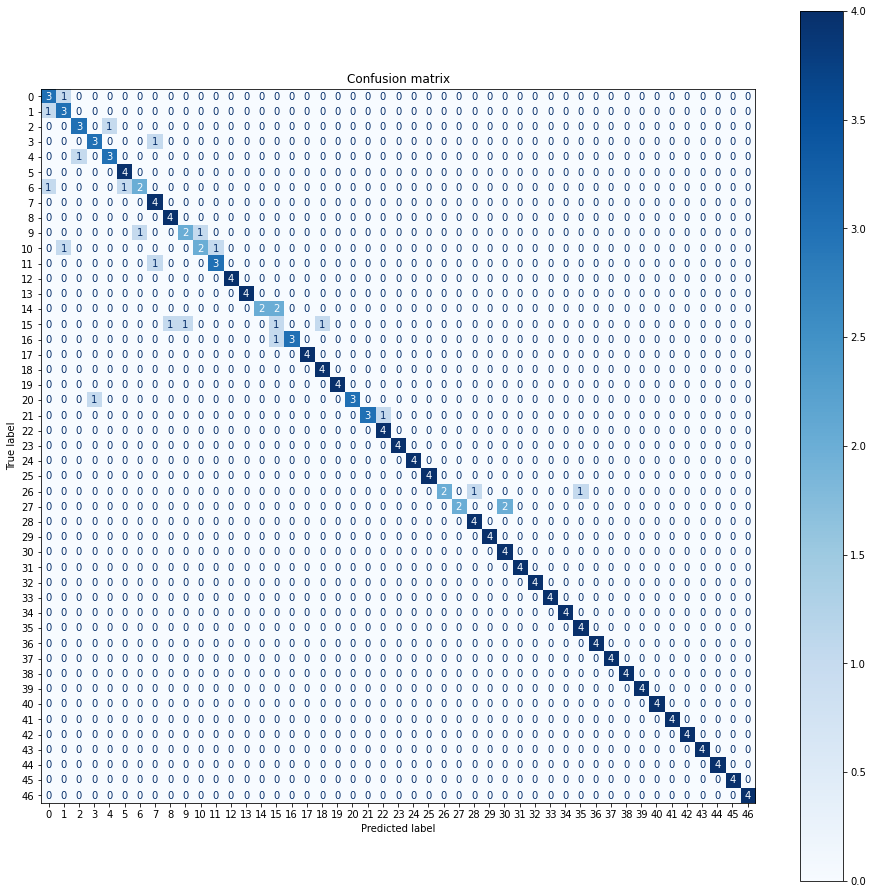

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_predictions = model.predict(x_test)

fig, ax = plt.subplots(figsize=(16, 16))

confusion_matrix = ConfusionMatrixDisplay.from_predictions(
    tensorflow.argmax(y_test, 1),
    tensorflow.argmax(y_predictions, 1),
    display_labels=[i for i in range(47)],
    cmap=plt.cm.Blues,
    normalize=None,
    ax=ax
)
confusion_matrix.ax_.set_title("Confusion matrix")

plt.show()

### More evaluation metrics
Shows for each user id:

*   True positive rate.
*   True negative rate.
*   False positive rate.
*   False negative rate.
*   Overall acurracy.

In [ ]:
FP = confusion_matrix.confusion_matrix.sum(axis=0) - np.diag(confusion_matrix.confusion_matrix)  
FN = confusion_matrix.confusion_matrix.sum(axis=1) - np.diag(confusion_matrix.confusion_matrix)
TP = np.diag(confusion_matrix.confusion_matrix)
TN = confusion_matrix.confusion_matrix.sum() - (FP + FN + TP)

matrix = np.zeros((47,5))
print('User_Id'+'\t\t '+'TPR'+'\t '+'TNR'+'\t '+'FPR'+'\t '+'FNR'+'\t '+'ACC')
print('-----------------------------------------------------')
for i in range(47):
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP[i]/(TP[i]+FN[i])
    matrix[i,0] = TPR
    # Specificity or true negative rate
    TNR = TN[i]/(TN[i]+FP[i])
    matrix[i,1] = TNR
    # Fall out or false positive rate
    FPR = FP[i]/(FP[i]+TN[i])
    matrix[i,2] = FPR
    # False negative rate
    FNR = FN[i]/(TP[i]+FN[i])
    matrix[i,3] = FNR

    # Overall accuracy
    ACC = (TP[i]+TN[i])/(TP[i]+FP[i]+FN[i]+TN[i])
    matrix[i,4] = ACC
    print('user_id',i , '\t', *[str(round(i,2))+'\t' for i in matrix[i,:]])


User_Id		 TPR	 TNR	 FPR	 FNR	 ACC
-----------------------------------------------------
user_id 0 	 0.75	 0.99	 0.01	 0.25	 0.98	
user_id 1 	 0.75	 0.99	 0.01	 0.25	 0.98	
user_id 2 	 0.75	 0.99	 0.01	 0.25	 0.99	
user_id 3 	 0.75	 0.99	 0.01	 0.25	 0.99	
user_id 4 	 0.75	 0.99	 0.01	 0.25	 0.99	
user_id 5 	 1.0	 0.99	 0.01	 0.0	 0.99	
user_id 6 	 0.5	 0.99	 0.01	 0.5	 0.98	
user_id 7 	 1.0	 0.99	 0.01	 0.0	 0.99	
user_id 8 	 1.0	 0.99	 0.01	 0.0	 0.99	
user_id 9 	 0.5	 0.99	 0.01	 0.5	 0.98	
user_id 10 	 0.5	 0.99	 0.01	 0.5	 0.98	
user_id 11 	 0.75	 0.99	 0.01	 0.25	 0.99	
user_id 12 	 1.0	 1.0	 0.0	 0.0	 1.0	
user_id 13 	 1.0	 1.0	 0.0	 0.0	 1.0	
user_id 14 	 0.5	 1.0	 0.0	 0.5	 0.99	
user_id 15 	 0.25	 0.98	 0.02	 0.75	 0.97	
user_id 16 	 0.75	 1.0	 0.0	 0.25	 0.99	
user_id 17 	 1.0	 1.0	 0.0	 0.0	 1.0	
user_id 18 	 1.0	 0.99	 0.01	 0.0	 0.99	
user_id 19 	 1.0	 1.0	 0.0	 0.0	 1.0	
user_id 20 	 0.75	 1.0	 0.0	 0.25	 0.99	
user_id 21 	 0.75	 1.0	 0.0	 0.25	 0.99	
user_id 22 	 1.0	 0.

### Iterative k-fold cross validation
1.   Shuffle users and samples.
2.   Split data into two subsets (folds, tests). The folds subset contains k subsets.
3.   Use k-1 subsets to train the model and 1 subset for validation, evaluating on tests.
4.   Repeat k times step 3 using a diferent validation subset.
5.   Go to step 1 and repeat the process as many times as you want.
6.   Get average results.




#### Get list of k lists with the indices of each fold per list

In [ ]:
def get_folds_indices(data, k=8): 
    
    data_samples = len(data)
    data_attempts = data_samples // categories
    step = data_attempts // k

    folds_indices = [ [] for _ in range(k) ]
    
    for category in range(categories):
        fold_index = 0
        for j in range(0, data_attempts, step):
            for i in range(j, j + step): 
                folds_indices[fold_index].append(data_attempts * category + i)  
            fold_index += 1

    return folds_indices

#### Get training and validation of a specific fold


In [ ]:
def get_fold(folds_indices, all_data, all_labels, iteration):
    x_train_fold = np.empty((0, all_data.shape[1], data.shape[2]), float)
    y_train_fold = np.empty((0, all_labels.shape[1]), float)
    
    for j in range(iteration):
        x_train_fold = np.concatenate((x_train_fold, all_data[folds_indices[j],:,:]), axis=0)
        y_train_fold = np.concatenate((y_train_fold, all_labels[folds_indices[j],:]), axis=0)

    x_validation_fold = all_data[folds_indices[iteration],:,:]
    y_validation_fold = all_labels[folds_indices[iteration],:]

    for j in range(iteration+1, len(folds_indices)):
        x_train_fold = np.concatenate((x_train_fold, all_data[folds_indices[j],:,:]), axis=0)
        y_train_fold = np.concatenate((y_train_fold, all_labels[folds_indices[j],:]), axis=0)

    return x_train_fold, y_train_fold, x_validation_fold, y_validation_fold



#### K-fold cross validation

In [ ]:
def k_fold(all_data, all_labels, x_test, y_test, k_value=8):

    scores = []

    folds_indices = get_folds_indices(all_data, k=k_value)

    for i in range(k_value):

        x_train_fold, y_train_fold, x_validation_fold, y_validation_fold = get_fold(folds_indices, all_data, all_labels, i)

        evaluation_model = create_model(x_train_fold, summary=False)
        evaluation_history = compile_and_fit(evaluation_model, x_train_fold, y_train_fold,
                                            x_validation_fold, y_validation_fold)
        
        evaluation = evaluation_model.evaluate(x_test, y_test, verbose=0)

        scores.append([evaluation_history.history['val_loss'][-1],
                      evaluation_history.history['val_categorical_accuracy'][-1],
                      evaluation[0], evaluation[1]])

        print(f'\t-Score for fold {i+1}:')
        print(f'\t\t-Validation_val_loss of {evaluation_history.history["val_loss"][-1]:.2f}')
        print(f'\t\t-Valiation_val_accuracy of {evaluation_history.history["val_categorical_accuracy"][-1]:.2f}')
        print(f'\t\t-Evaluation_val_loss of {evaluation[0]:.2f}')
        print(f'\t\t-Evaluation_val_accuracy of {evaluation[1]:.2f}\n')

    return scores

#### Iterative k-fold


In [ ]:
def iterative_k_fold(all_data, all_labels, k=8, iterations=2):
    scores = []

    for iter in range(iterations):
        print(f'\nIteracion nº{iter+1}')
        all_data, all_labels = shuffle(all_data, all_labels)
        x_train_and_validation, y_train_and_validation, x_test, y_test = split(all_data, all_labels, validation=0.2)
        scores += k_fold(x_train_and_validation, y_train_and_validation, x_test, y_test, k_value=k)

    return scores
  
scores = iterative_k_fold(data, labels, k=8, iterations=2)


Iteracion nº1
	-Score for fold 1:
		-Validation_val_loss of 0.39
		-Valiation_val_accuracy of 0.91
		-Evaluation_val_loss of 0.39
		-Evaluation_val_accuracy of 0.90

	-Score for fold 2:
		-Validation_val_loss of 0.47
		-Valiation_val_accuracy of 0.87
		-Evaluation_val_loss of 0.45
		-Evaluation_val_accuracy of 0.87

	-Score for fold 3:
		-Validation_val_loss of 0.33
		-Valiation_val_accuracy of 0.90
		-Evaluation_val_loss of 0.36
		-Evaluation_val_accuracy of 0.89

	-Score for fold 4:
		-Validation_val_loss of 0.36
		-Valiation_val_accuracy of 0.89
		-Evaluation_val_loss of 0.40
		-Evaluation_val_accuracy of 0.89

	-Score for fold 5:
		-Validation_val_loss of 0.27
		-Valiation_val_accuracy of 0.88
		-Evaluation_val_loss of 0.35
		-Evaluation_val_accuracy of 0.91

	-Score for fold 6:
		-Validation_val_loss of 0.52
		-Valiation_val_accuracy of 0.87
		-Evaluation_val_loss of 0.44
		-Evaluation_val_accuracy of 0.87

	-Score for fold 7:
		-Validation_val_loss of 0.47
		-Valiation_val_accur

#### Display boxplot and results
Compare validation and tests results

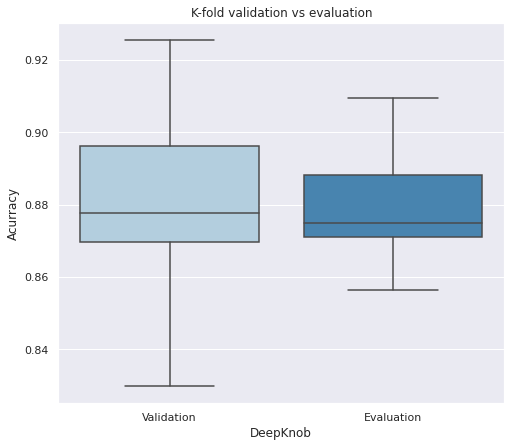


Average Validation Loss: 0.415
Average Validation Accuracy: 0.880
Average Evaluation Loss: 0.404
Average Evaluation Accuracy: 0.879


In [ ]:
import pandas as pd
import seaborn as sns

val_loss_scores = []
val_accuracy_scores = []
test_loss_scores = []
test_accuracy_scores = []
for score in scores:
    val_loss_scores.append(score[0])
    val_accuracy_scores.append(score[1])
    test_loss_scores.append(score[2])
    test_accuracy_scores.append(score[3])


val_folds_loss = sum(val_loss_scores) / len(scores)
val_folds_accuracy = sum(val_accuracy_scores) / len(scores)

test_folds_loss = sum(test_loss_scores) / len(scores)
test_folds_accuracy = sum(test_accuracy_scores) / len(scores) 

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8, 7)})

df = pd.DataFrame({'Validation': val_accuracy_scores,
                   'Evaluation': test_accuracy_scores})

sns.boxplot(x='variable',
            y='value',
            data=pd.melt(df),
            palette='Blues').set(title='K-fold validation vs evaluation')

plt.xlabel('DeepKnob')
plt.ylabel('Acurracy')
plt.show()

print(f'\nAverage Validation Loss: {val_folds_loss:.3f}')
print(f'Average Validation Accuracy: {val_folds_accuracy:.3f}')
print(f'Average Evaluation Loss: {test_folds_loss:.3f}')
print(f'Average Evaluation Accuracy: {test_folds_accuracy:.3f}')